<a href="https://colab.research.google.com/github/IdeaTechsquad/ML-Models/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [64]:
df = pd.read_csv("/content/train_data_cleaned.csv")

df.head()

,Customer_ID,outlet_city_0,outlet_city_1,outlet_city_2,outlet_city_3,outlet_city_4,luxury_sales,fresh_sales,dry_sales,cluster_category
0,10493832.0,0,0,0,0,1,1209.60,756.00,5292.00,4
1,10178643.0,0,0,0,1,0,1590.12,1060.08,6007.12,1
2,10513916.0,0,0,0,1,1,2288.88,1481.04,9155.52,4
3,10334589.0,0,0,0,1,1,2274.94,1739.66,9099.76,4
4,10458365.0,0,0,0,0,1,2345.49,2069.55,9243.99,4


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739088 entries, 0 to 739087
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Customer_ID       739088 non-null  float64
 1   outlet_city_0     739088 non-null  int64  
 2   outlet_city_1     739088 non-null  int64  
 3   outlet_city_2     739088 non-null  int64  
 4   outlet_city_3     739088 non-null  int64  
 5   outlet_city_4     739088 non-null  int64  
 6   luxury_sales      739088 non-null  float64
 7   fresh_sales       739088 non-null  float64
 8   dry_sales         739088 non-null  float64
 9   cluster_category  739088 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 56.4 MB


In [66]:
# traindf splitting to train_test_split
from sklearn.model_selection import train_test_split

# dropping the columns
X = df.drop(columns=["Customer_ID", "cluster_category"])
y = df["cluster_category"]


In [63]:
#check that the list of input variables
list(X)

['outlet_city_0',
 'outlet_city_1',
 'outlet_city_2',
 'outlet_city_3',
 'outlet_city_4',
 'luxury_sales',
 'fresh_sales',
 'dry_sales']

In [67]:
# Before creating LightGBM datasets, ensure labels are in the correct range
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the target variable and transform it
y_encoded = label_encoder.fit_transform(y)

# encoded target variable for splitting and creating LightGBM datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=14, stratify=y_encoded)

In [68]:
# Number of instances and input features in the training and test sets
print('X_train Instances', X_train.shape)
print('X_test Instances', X_test.shape)

X_train Instances (591270, 8)
X_test Instances (147818, 8)


In [69]:
#Robust scaling
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
from imblearn.over_sampling import SMOTE
# For handling imbalanced data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [95]:
# Create LightGBM dataset format
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Optimized parameters
params = {
    "objective": "multiclass",
    "num_class": len(np.unique(y)),
    "metric": "multi_logloss",
    "boosting_type": "dart",
    "learning_rate": 0.005,
    "class_weight" : "balanced",
    "num_leaves": 60,
    "max_depth": 7,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.6,
    "bagging_freq": 4,
    "lambda_l1": 1.0,
    "lambda_l2": 1.0,
    "num_threads": 4,
    "device": "cpu",
    "early_stopping_rounds": 50
}

num_boost_round = 150

# Train LightGBM with early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=num_boost_round,
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 907098, number of used features: 8
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [96]:
#Make predictions
y_pred = model.predict(X_test)
y_pred_classes = [np.argmax(line) for line in y_pred]

In [97]:
# Evaluate model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_classes))

Accuracy: 0.9926
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     37796
           1       0.99      1.00      1.00     31012
           2       1.00      0.90      0.95      4822
           3       0.99      1.00      0.99     34487
           4       0.92      1.00      0.96      5859
           5       1.00      0.99      1.00     33842

    accuracy                           0.99    147818
   macro avg       0.98      0.98      0.98    147818
weighted avg       0.99      0.99      0.99    147818



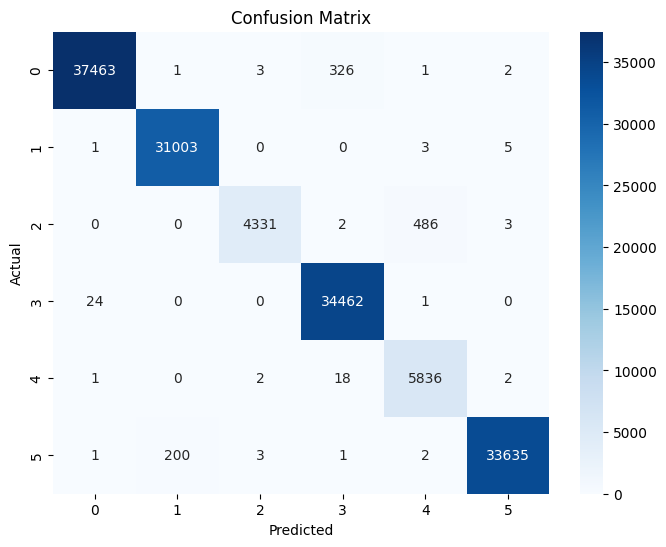

In [98]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

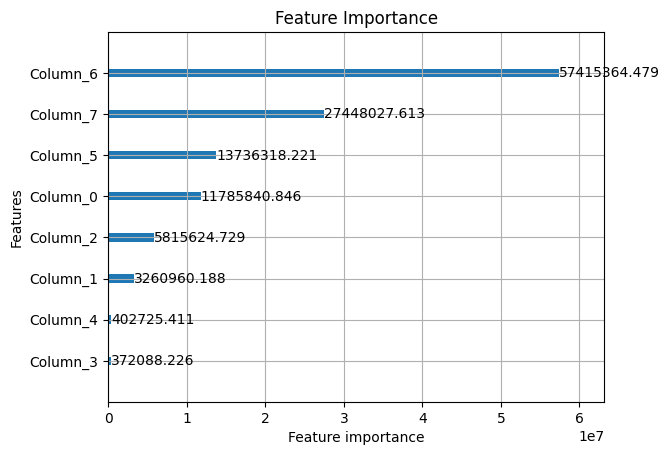

In [105]:
# Feature importance visualization
lgb.plot_importance(model, max_num_features=10, importance_type="gain")
plt.title("Feature Importance")
plt.show()

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 907098, number of used features: 8
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

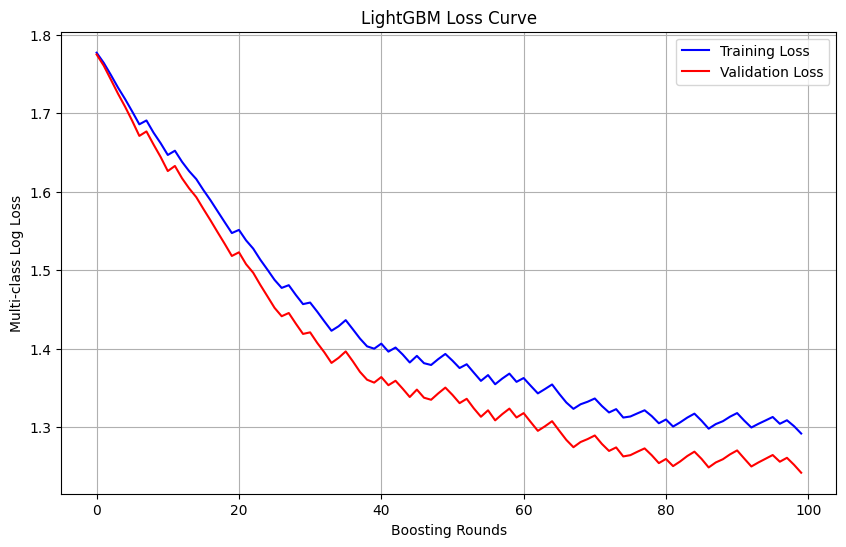

In [99]:
# Dictionary to store training history
evals_result = {}

# Train LightGBM model and log loss values
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=["Train", "Validation"],
    num_boost_round=100,
    # 'early_stopping_rounds' is moved to the callbacks list
    callbacks=[lgb.early_stopping(20, verbose=True), lgb.record_evaluation(evals_result)],
)

# Extract loss values
train_loss = evals_result["Train"]["multi_logloss"]
val_loss = evals_result["Validation"]["multi_logloss"]
epochs = range(len(train_loss))

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", color="blue")
plt.plot(epochs, val_loss, label="Validation Loss", color="red")
plt.xlabel("Boosting Rounds")
plt.ylabel("Multi-class Log Loss")
plt.title("LightGBM Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

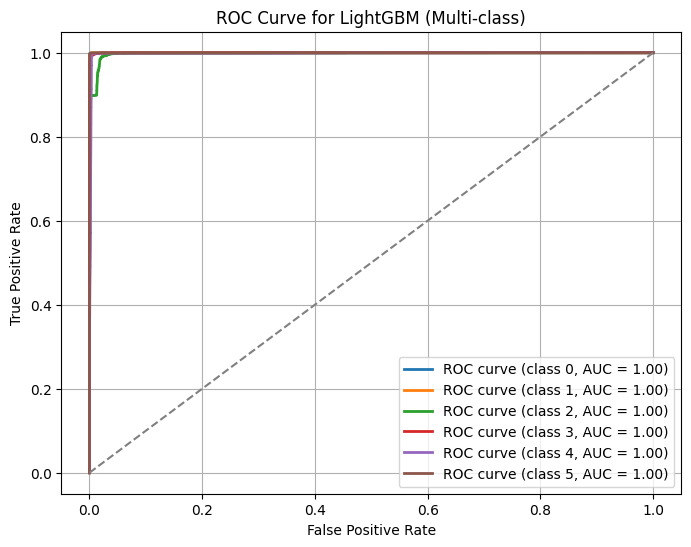

In [100]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt


# Assuming y_test has labels 0, 1, 2...
n_classes = len(np.unique(y_test))  # Get the number of classes

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # Get predicted probabilities for class i
    y_pred_prob_class_i = model.predict(X_test)[:, i]

    # Compute ROC curve and AUC for class i
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob_class_i, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"ROC curve (class {i}, AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for LightGBM (Multi-class)")
plt.legend(loc="lower right")
plt.grid()
plt.show()